# Imports

In [2]:
from pathlib import Path
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# Useful functions

In [3]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [4]:
def interpolate_nans(data):

    data_interp = data.copy()
    for i in range(data_interp.shape[0]):
        y = data_interp[i,:]
        nans, x = nan_helper(y)
        y[nans]= np.interp(x(nans), x(~nans), y[~nans])
        data_interp[i,:] = y
    return data_interp

In [5]:
def one_phase_ass(t, y0, ylim, k):
    return y0 + (ylim - y0) * (1 - np.exp(-k * t))

In [6]:
def shuffle_data(data, rng):
    data_copy = data.copy()
    rng.shuffle(data_copy,axis=0)
    return data_copy

In [7]:
def compute_means(data, n1):
    data1_mean = np.nanmean(data[:n1], axis=0)
    data2_mean = np.nanmean(data[n1:], axis=0)
    return np.vstack((data1_mean, data2_mean))

In [8]:
def compute_stderr(data, n1):
    n2 = data.shape[0] - n1
    data1_stderr = np.nanstd(data[:n1], axis=0) / np.sqrt(n1)
    data2_stderr = np.nanstd(data[n1:], axis=0) / np.sqrt(n2)
    return np.vstack((data1_stderr, data2_stderr))

In [9]:
def fit_params(data, fun, x, bounds):
    n_dat = data.shape[0]
    params_fit = []
    for i in range(n_dat):
        popt, _ = curve_fit(fun, x, data[i,:], bounds=bounds)
        params_fit.append(popt)
    return params_fit

In [10]:
def compute_mean_fit(data, n1, fun, bounds):
    n_trials = data.shape[1]
    x = np.arange(1,n_trials+1)
    data_means = compute_means(data, n1)
    params_fit = fit_params(data_means, one_phase_ass,x, bounds)
    data1_mean = data_means[0,:]
    data2_mean = data_means[1,:]
    params1 = params_fit[0]
    params2 = params_fit[1]
    return data1_mean, data2_mean, params1, params2

In [11]:
def compute_params_suffle(data,rng,n1,fun,bounds,n_shuffle,n_params=3):
    n_trials = data.shape[1]
    x = np.arange(1,n_trials+1)
    
    params_shuffle_ctr = np.empty((n_shuffle,n_params))
    params_shuffle_h3 = np.empty((n_shuffle,n_params))

    for i_shuf in range(n_shuffle):
        data_permut = shuffle_data(data, rng)
        data_means = compute_means(data_permut, n1)
        params_shuffle_all = fit_params(data_means,one_phase_ass, x,bounds)
        params_shuffle_ctr[i_shuf,:] = np.array(params_shuffle_all[0])
        params_shuffle_h3[i_shuf,:] = np.array(params_shuffle_all[1])   
    return params_shuffle_h3, params_shuffle_ctr


In [12]:
def compute_params_suffle_single_anim(data,rng,n_shuffle):
    n_params = data.shape[1]
    
    params_shuffle_ctr = np.empty((n_shuffle,n_params))
    params_shuffle_h3 = np.empty((n_shuffle,n_params))

    for i_shuf in range(n_shuffle):
        data_permut = shuffle_data(data, rng)
        data_means = compute_means(data_permut, n1)
        params_shuffle_ctr[i_shuf,:] = data_means[0]
        params_shuffle_h3[i_shuf,:] = data_means[1]   
    return params_shuffle_h3, params_shuffle_ctr


In [13]:
def plot_fit_stats_results(data, n1, data_h3_fit, data_ctr_fit, 
                           params_h3,  params_ctr, params_shuffle_diff, fit_tau, fig_path):
    
    n_params = params_shuffle_diff.shape[1]
    
    data_means = compute_means(data, n1)
    data_ctr_mean = data_means[0,:]
    data_h3_mean = data_means[1,:]    
    
    data_stderr = compute_stderr(data, n1)
    data_ctr_stderr = data_stderr[0,:]
    data_h3_stderr = data_stderr[1,:]     
    
    
    if fit_tau:
        params_names = ['y0', 'plateau', 'tau']
    else:
        params_names = ['y0', 'plateau', 'cost rate']
        
    
    colors_list = ['deepskyblue', 'orangered']

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,3.5), gridspec_kw={'width_ratios': [2, 1, 1, 1]})

    axs[0].errorbar(t, data_h3_mean,data_h3_stderr,marker='o',linestyle='--',color=colors_list[0],alpha=.3)
    axs[0].plot(t, data_h3_fit,color=colors_list[0],linewidth=2, label='h3')
    axs[0].errorbar(t, data_ctr_mean,data_ctr_stderr,marker='o',linestyle='--',color=colors_list[1],alpha=.3)
    axs[0].plot(t, data_ctr_fit,color=colors_list[1],linewidth=2,label='control')
    axs[0].spines[['top', 'right']].set_visible(False)
    axs[0].set_xlabel('Trial #');
    axs[0].set_ylabel('Mean silhouette score');
    axs[0].legend();

    for i in range(n_params):
        ax = axs[i+1]
        
        param_diff = params_h3[i] - params_ctr[i]

        if (fit_tau) and (i==2): 
            perc_ref = np.percentile(params_shuffle_diff[:,i],5)
            significant = params_h3[i] - params_ctr[i] < perc_ref
        else:
            perc_ref = np.percentile(params_shuffle_diff[:,i],95)
            significant = params_h3[i] - params_ctr[i] > perc_ref
            
        pval = np.sum(params_shuffle_diff[:,i] > params_h3[i] - params_ctr[i]) / params_shuffle_diff.shape[0]
        print(params_names[i] + ' p = ' + str(pval))
        
        res_hist = ax.hist(params_shuffle_diff[:,i],edgecolor='white',alpha=.5)
        ymin = 0 
        ymax = np.max(res_hist[0])
        ax.vlines(perc_ref, ymin, ymax, color='r',linewidth=3)
        ax.vlines(param_diff, ymin, ymax, color='g',linewidth=3)
        ax.spines[['top', 'right']].set_visible(False)

        if significant:
            ax.set_title('Significant difference:' + params_names[i])
        else:
            ax.set_title('NOT significant diff: ' + params_names[i])


    fig.savefig(fig_path, format="png", bbox_inches="tight", dpi=100)

In [14]:
def plot_data_time_course(data, n1, data_h3_fit, data_ctr_fit, fig_path):
        
    data_means = compute_means(data, n1)
    data_ctr_mean = data_means[0,:]
    data_h3_mean = data_means[1,:]    
    
    data_stderr = compute_stderr(data, n1)
    data_ctr_stderr = data_stderr[0,:]
    data_h3_stderr = data_stderr[1,:]     
    
    
    colors_list = ['orangered', 'deepskyblue']

    fig, ax = plt.subplots(figsize=(7,3.5))

    ax.errorbar(t, data_h3_mean,data_h3_stderr,marker='o',linestyle='--',color=colors_list[0],alpha=.3)
    ax.plot(t, data_h3_fit,color=colors_list[0],linewidth=2, label='h3')
    ax.errorbar(t, data_ctr_mean,data_ctr_stderr,marker='o',linestyle='--',color=colors_list[1],alpha=.3)
    ax.plot(t, data_ctr_fit,color=colors_list[1],linewidth=2,label='control')
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Trial #');
    ax.set_ylabel('Mean silhouette score');
    ax.legend();
    fig.savefig(fig_path, format="svg", bbox_inches="tight", dpi=100)

# Datafolder definition
Here you should put the folders where the data are

In [15]:
main_dir = '/home/stef/projects/rotariu_zalcman_2025'

xlsx_dir = main_dir + '/files_xlsx'

pickle_dir = main_dir + '/results/pickle/'
plots_dir = main_dir + '/results/plots/'

# Main code

In [16]:
file_to_open = pickle_dir + 'ctr_h3_silh_results.pikcle'
results_sil = pickle.load(open(file_to_open, "rb"))

In [17]:
ctr_h3_silh_dict = results_sil['ctr_h3_silh_dict']
control_h3_dict = results_sil['control_h3_dict']

n_ctr = len(ctr_h3_silh_dict['ctr'])
silh_all = np.vstack((ctr_h3_silh_dict['ctr'],ctr_h3_silh_dict['h3']))
fit_tau = False

In [18]:
data = silh_all
n_trials = data.shape[1]
n1 = n_ctr

if fit_tau:
    fun_fit = one_phase_ass_tau
    bounds = ([0., 0., 1.],[1.,1., n_trials / 2])
else:
    fun_fit = one_phase_ass
    bounds = ([0, 0, 2/n_trials],[1.,1., 1])

In [19]:
silh_ctr_mean, silh_h3_mean, params_silh_ctr, params_silh_h3 = compute_mean_fit(
    data=data, n1=n1, fun=fun_fit, bounds=bounds)

In [20]:
n_shuffle = 1000
rng = np.random.default_rng()

params_shuffle_silh_h3, params_shuffle_silh_ctr = compute_params_suffle(
    data=data,rng=rng,n1=n1,fun=fun_fit,bounds=bounds,n_shuffle=n_shuffle,n_params=3)

params_shuffle_silh_diff =  params_shuffle_silh_h3 - params_shuffle_silh_ctr

In [21]:
t = np.arange(1,n_trials+1)
silh_ctr_fit = fun_fit(t, *params_silh_ctr)
silh_h3_fit = fun_fit(t, *params_silh_h3)
n_params = len(params_silh_h3)

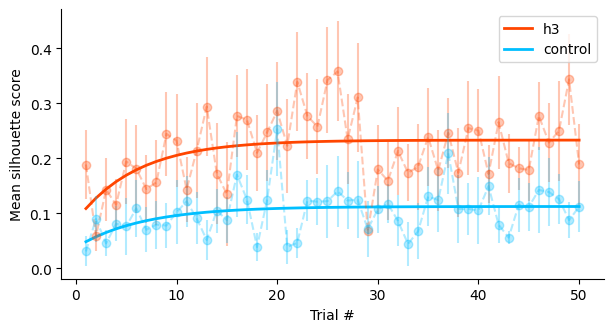

In [22]:
fig_path = plots_dir + 'silhouette_timecourse.svg'
plot_data_time_course(data=data, n1=n1, 
                      data_h3_fit=silh_h3_fit, data_ctr_fit=silh_ctr_fit, 
                      fig_path=fig_path)